<div class="alert" style="background-color:#fff; color:white; padding:0px 10px; border-radius:5px;"><h1 style='margin:15px 15px; color:#305496; font-size:40px'> Previsão de Vazões de Rios</h1>
</div>


Esse trabalho tem como objetivo demonstrar o processo de projeção através de modelos de séries temporais. Para isso, utilizaremos os dados das vazões de um rio, fornecidos pelo Operador Nacional de Sistemas Elétrico (ONS), medidos mensalmente entre 1984 e 2004. Tais dados serão submetidos ao modelo ARIMA, que estará apto a projetar vazões do rio em estudo.

O processo inicia pela análise dos dados para verificar se estes estão dentro das característcas de estacionaridade e aderência à distribuição normal. No próximo passo é aplicada as técnicas de transformação para ajustar os dados a fim de alcançar as referidas características. Na sequência, é feito a modelagem onde chegou-se a conclusão que o modelo ARIMA apresentou o melhor resultado, para a projeção das vazões.

### Conteúdo:

1. Importação das bibliotecas

2. Análise de dados
  - Carga dos dados
  - Análise da Estrutura
  - Análise Exploratória
  - Verificação da Estacionaridade
  - Aderência a Distribuição Normal
  - Decomposição da Série
  - Conclusão

3. Transformação da Série
  - Suavização
  - Aderência a Distribuição Normal
  - Verificação da Estacionaridade
  - Conclusão

4. Modelagem
  - Análise da Autocorrelação
  - Treinamento
  - Análise dos Resíduos
  - Análise do Ajuste
  - Funções de Projeção
  - Teste
  - Conclusão

5. Validação
  - Validação para 2005
  - Validação para 2006
  - Conclusão

6. Resultado

  

<div class="alert alert-info" style="background-color:#A6A6A6; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'>1. Importação das bibliotecas</h2>
</div>

In [209]:
%matplotlib inline

import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6
import seaborn as sns

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.stats.diagnostic import acorr_ljungbox
from scipy.stats import shapiro
import scipy.stats as stats

from statsmodels.tsa.arima.model import ARIMA

<div class="alert alert-info" style="background-color:#A6A6A6; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'>2. Análise de dados</h2>
</div>

Nesta seção:
  - Carga dos dados
  - Análise da estrutura
  - Análise Exploratória
  - Verificação da Estacionaridade
  - Aderência a Distribuição Normal.
  - Decomposição da Série

### 2.1. Carga de Dados

Serão carregados 20 anos de vazões com periodicidade mensal.

In [210]:
date_parser = lambda dates: datetime.strptime(dates, '%d/%m/%Y')

data = pd.read_csv('Vazoes_Mensais.csv', 
                   sep=";", header=0, index_col=0, date_parser=date_parser)

### 2.2. Análise da Estrutura

A estrutura de dados de uma série temporal univariada no pandas deve ter como índice o tempo e um campo de valor, neste caso um índice com uma data mensal e uma valor para a vazão.

In [211]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 252 entries, 1984-01-01 to 2004-12-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Vazao   252 non-null    int64
dtypes: int64(1)
memory usage: 3.9 KB


### 2.3. Análise Exploratória

Nesta seção será verificado:

  - Quantidade de Dados.
  - Existência de dados nulos e como completa-los.
  - Existência de vazões com valor zero que pode influênciar na seção de transformação dos dados.
  - Medição de valores discrepantes (Outliers).
  

In [212]:
print(f'Quantidade de valores: {len(data)}')
print(f'Quantidade de dados nulos: {data["Vazao"].isnull().sum()}')
print(f'Quantidade de valores zerados: {len(data.loc[data["Vazao"] == 0].value_counts())}')

Quantidade de valores: 252
Quantidade de dados nulos: 0
Quantidade de valores zerados: 0


In [213]:
# Medição dos outliers

In [214]:
data.head()

,Vazao
Data,
1984-01-01,2192
1984-02-01,1315
1984-03-01,994
1984-04-01,914
1984-05-01,861


### 2.4. Verificação da Estacionariedade

Nesta seção será plotado os dados da vazão ao longo dos meses para verificar visualente se a série pode ser estacionária.

Para confirmar a análise visual, será aplicado o teste de Dickey-Fuller para confirmar a estacionaridade da série temporal.

In [215]:
# Função de aplicação do teste de Dickey-Fuller que retorna um valor binnário se série é estacionária.

def isStationary(values, print_results=False):
    dfuller = adfuller(values, autolag='AIC')
    result = pd.Series(dfuller[0:4], index=['Teste', 'Valor-p', '# Lags', '# Obs'])
    for key, value in dfuller[4].items():
        result[f'Valores Críticos({key})'] = value
    if print_results:
        print(result)
    is_tationary = True if result['Valor-p'] < 0.5 else False
    return is_tationary

Text(0, 0.5, 'Vazao')

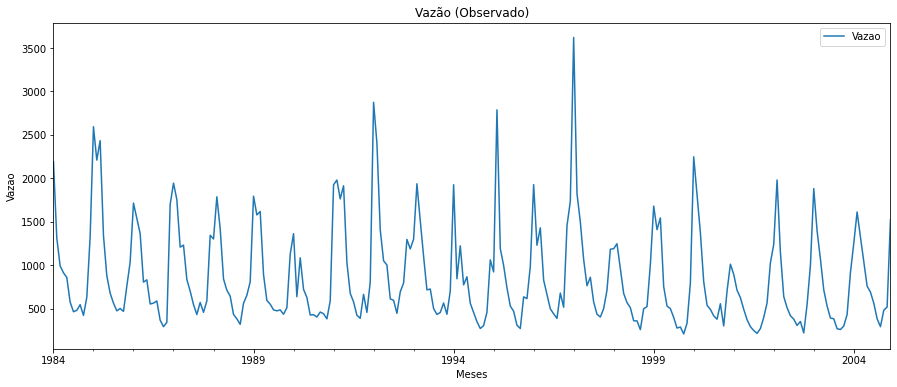

In [216]:
data.plot()
plt.title('Vazão (Observado)')
plt.xlabel('Meses')
plt.ylabel('Vazao')

In [217]:
if isStationary(data.Vazao.values):
    print('Série é estacionária')
else:
    print('Série não é estacionária')

Série é estacionária


### 2.5. Aderência a Distribuição Normal.

Nesta seção será plotado o histograma e o quantile-quantile para verificar visualmente se há aproximação da distribuição normal. Para confirmar a aderência será aplicado o teste Shapiro-Wilk.

#### Plotagem do histograma

<AxesSubplot:ylabel='Count'>

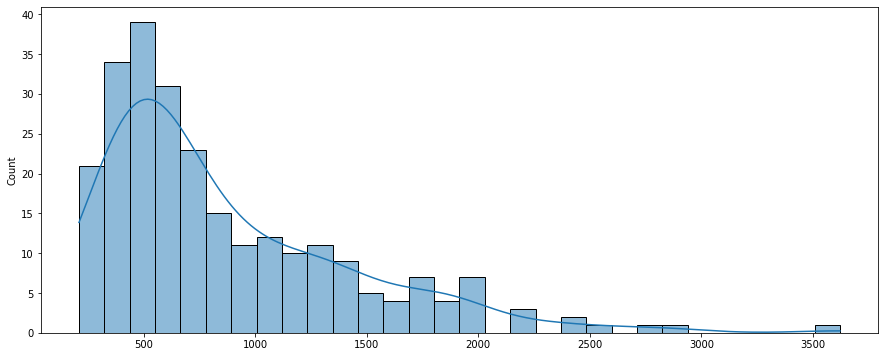

In [218]:
sns.histplot(data=data.Vazao.values, kde=True, bins=30)

#### Plotagem do quantile-quantile

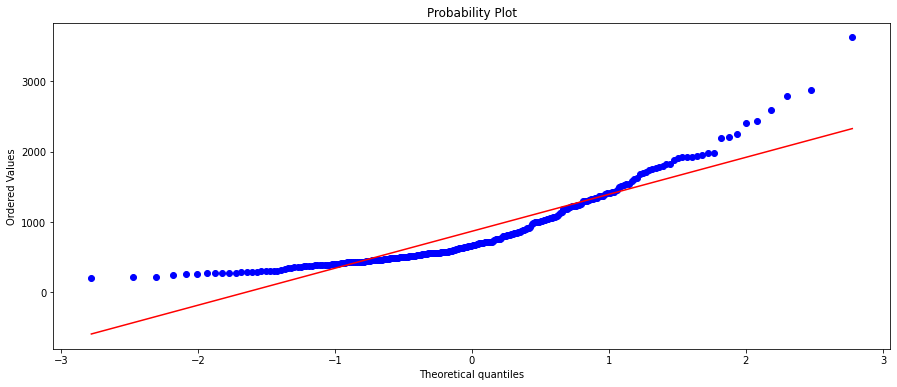

In [219]:
stats.probplot(data.Vazao.values, dist="norm", plot=plt)
plt.show()

#### Teste Shapiro-Wilk para aderência a distribuição normal.

In [220]:
shapiro_test = shapiro(data.Vazao.values)
print('Teste de normalidade')
print(f'Statisct Test: {shapiro_test.statistic}')
adhesion = 'aderente distribuição normal' if shapiro_test.pvalue > 0.05 else 'não aderente distribuição normal' 
print(f'p-value: {round(shapiro_test.pvalue, 5)} - Série Original {adhesion}')

Teste de normalidade
Statisct Test: 0.8536005616188049
p-value: 0.0 - Série Original não aderente distribuição normal


### 2.6. Decomposição da Série.

Nesta seção será visto através da decomposição da série se há tendência ou sazonalidade.

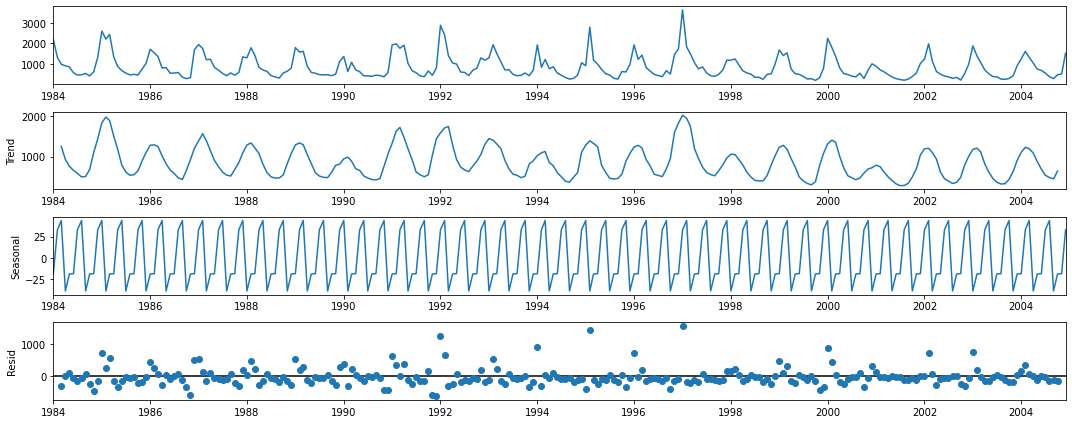

In [221]:
decompose = seasonal_decompose(data,  model='additive', period=5)
decompose.plot()
plt.show()

### 2.7. Conclusão

Apesar da série temporal apresentar escacionariadade, esta não é aderente a distribuição normal, apresentando uma leve tendência e uma acentuada sazonalidade.

Portanto, será necessário a transformação da série para alcançar as caracterisitcas supracitadas que não estão adequadas para o processo de modelagem.


<div class="alert alert-info" style="background-color:#A6A6A6; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'>3. Transformação da Série</h2>
</div>

Nesta Seção:
  - Suavização da Série
  - Aderência a Distribuição Normal
  - Aplicação Teste de Estacionariada
  - Análise da Autocorrelação
  
Para cada procedimento, será verificado se a série original não é aderente a distribuição normal, indicando a necessidade da aplicação listada acima.

### 3.1. Suavização da Série

Transfomando a série para aproximar a distribuição normal, remover sazonalidade e a tendência.

In [222]:
series = data.copy()

if shapiro_test.pvalue <= 0.05:
    # Transforma série para obter a aderência a distribuição normal.
    series['Vazao'] = np.log(series['Vazao'])
    # Copia a série transformada para fazer a diferenciação
    seriesd = series.copy()
    # Remove a sazonalidade a cada 12 meses.
    seriesd['Vazao'] = seriesd['Vazao'].diff(periods=12) 
    seriesd.dropna(axis=0, inplace=True)
    # Remoção da tendência.
    seriesd['Vazao'] = seriesd['Vazao'].diff(periods=1)
    seriesd.dropna(axis=0, inplace=True)

#### Plotando a série suavizado.

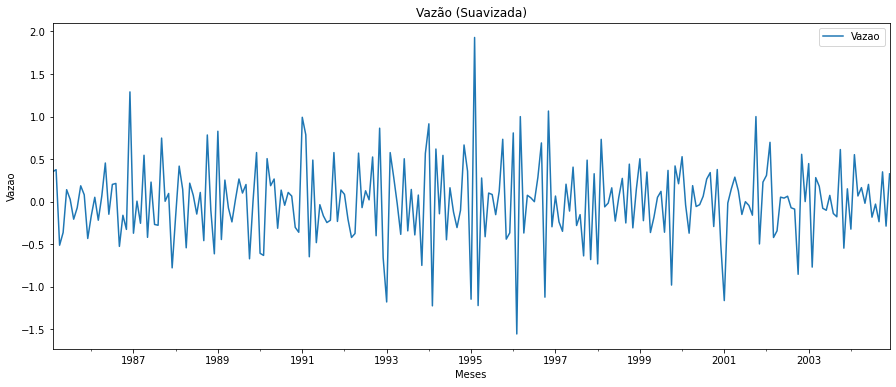

In [223]:
if shapiro_test.pvalue <= 0.05:
    seriesd.plot()
    plt.title('Vazão (Suavizada)')
    plt.xlabel('Meses')
    plt.ylabel('Vazao')


### 3.2. Aderência a Distribuição Normal

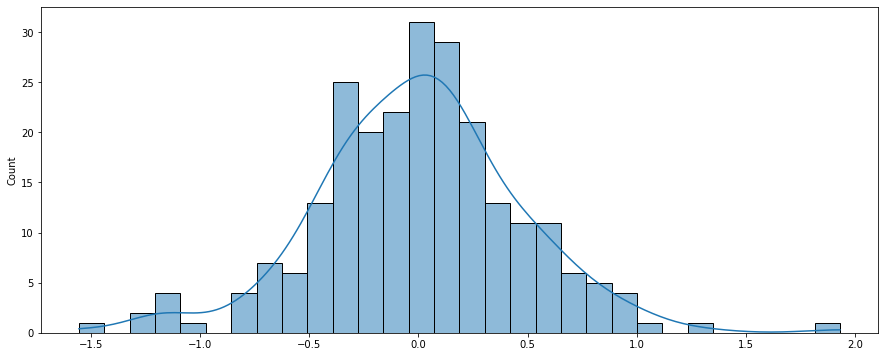

In [224]:
if shapiro_test.pvalue <= 0.05:
    sns.histplot(data=seriesd.Vazao.values, kde=True, bins=30)


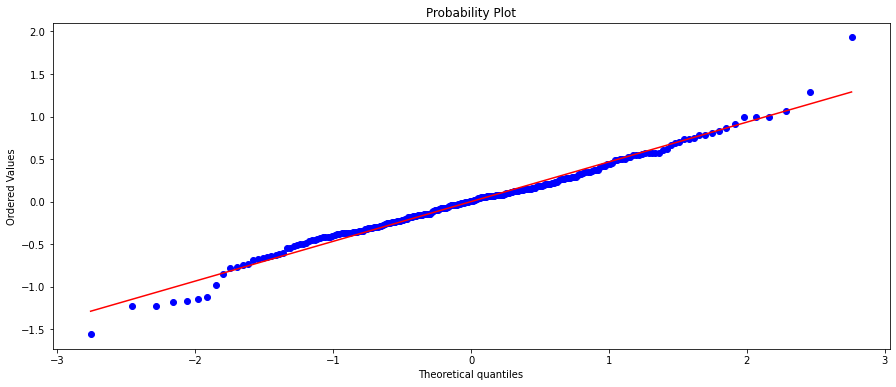

In [225]:
if shapiro_test.pvalue <= 0.05:
    stats.probplot(seriesd.Vazao.values, dist="norm", plot=plt)
    plt.show()

#### Teste de Shapiro-Wilk para verfifica a aderência a distribuição normal sobre a série suavizada.


In [226]:
if shapiro_test.pvalue <= 0.05:
    shapiro_test = shapiro(seriesd.Vazao.values)
    print('Teste de normalidade')
    print(f'Statisct Test: {shapiro_test.statistic}')
    adhesion = 'aderente distribuição normal' if shapiro_test.pvalue > 0.05 else 'não aderente distribuição normal' 
    print(f'p-value: {round(shapiro_test.pvalue, 5)} - Série Suavizada {adhesion}.')

Teste de normalidade
Statisct Test: 0.9838048219680786
p-value: 0.00799 - Série Suavizada não aderente distribuição normal.


### 3.3. Verificação da Estacionaridade

#### Teste de estacionaridade sobre a série suavizada.

In [227]:
if shapiro_test.pvalue <= 0.05:
    if isStationary(seriesd.Vazao.values):
        print('Série transformada é estacionária')
    else:
        print('Série transformada não é estacionária')       


Série transformada é estacionária


### 3.4. Conclusão

Apesar do teste Shapiro-Wilk não confirmar a aderência à distribuição normal, o gráfico quantile-quantile exibe que está próxima dessa distribuição de probabilidade. Com isso, pode-se dar continuidade a modelagem da série temporal.

<div class="alert alert-info" style="background-color:#A6A6A6; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'>4. Modelagem</h2>
</div>

Nesta Seção:
  - Análise da Autocorrelação
  - Treinamento
  - Análise dos Resíduos
  - Análise do Ajuste
  - Funções de Projeção
  - Teste
  - Conclusão


### 4.1. Análise da Autocorrelação



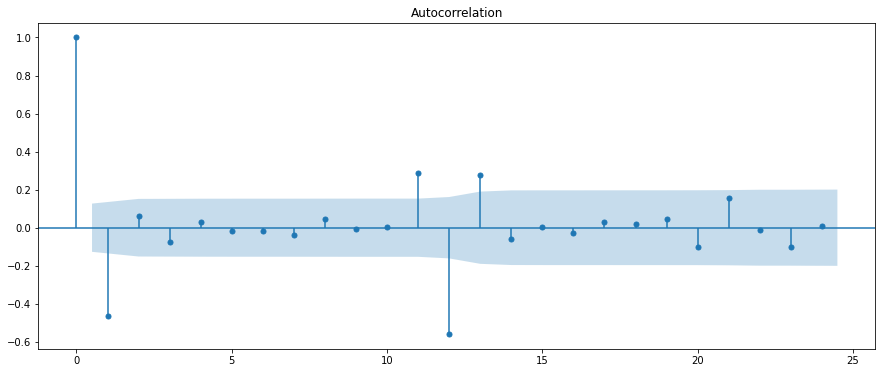

In [228]:
plot_acf(seriesd.Vazao.values)
plt.show()

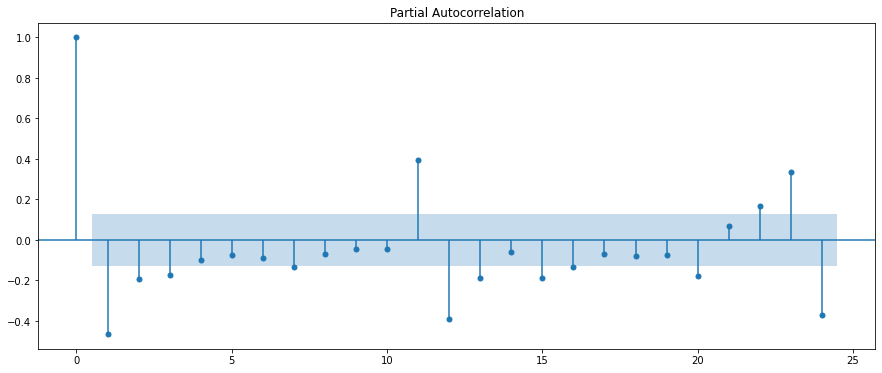

In [229]:
plot_pacf(seriesd.Vazao.values)
plt.show()

### 4.2. Treinamento

In [230]:
# Quebra os dados da série em treinamento e teste.
treshold = int(len(series) * 0.70)
train = series[:treshold]
test = series[treshold:]

In [231]:
# Aplica o modelo Arima para AutoRegressão e Média Móvel.
model = ARIMA(train, order=(3,1,1), seasonal_order=(1,1,1,12))

model_fit = model.fit()
print(model_fit.summary())


c:\users\rossana fiaschetti\.virtualenvs\rossana_fiaschetti-vaq17g4d\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
c:\users\rossana fiaschetti\.virtualenvs\rossana_fiaschetti-vaq17g4d\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
c:\users\rossana fiaschetti\.virtualenvs\rossana_fiaschetti-vaq17g4d\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
c:\users\rossana fiaschetti\.virtualenvs\rossana_fiaschetti-vaq17g4d\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retva

                                    SARIMAX Results                                     
Dep. Variable:                            Vazao   No. Observations:                  176
Model:             ARIMA(3, 1, 1)x(1, 1, 1, 12)   Log Likelihood                 -29.065
Date:                          Tue, 24 Aug 2021   AIC                             72.129
Time:                                  17:51:36   BIC                             93.785
Sample:                              01-01-1984   HQIC                            80.921
                                   - 08-01-1998                                         
Covariance Type:                            opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2358      0.112      2.102      0.036       0.016       0.456
ar.L2          0.0607      0.087      0.702      0.

### 4.3. Análise dos Resíduos

c:\users\rossana fiaschetti\.virtualenvs\rossana_fiaschetti-vaq17g4d\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


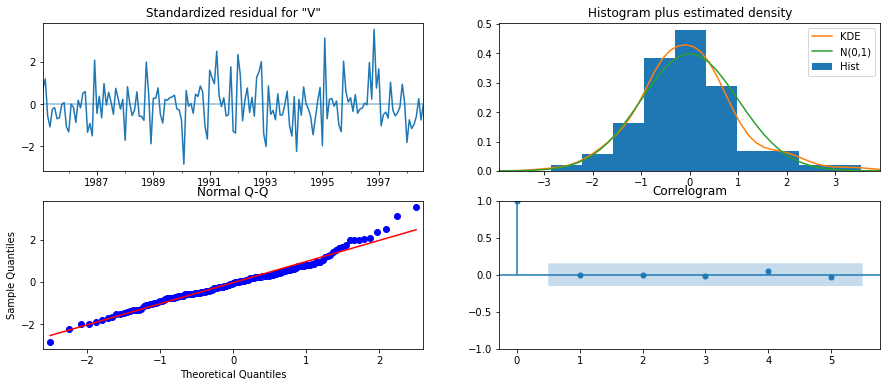

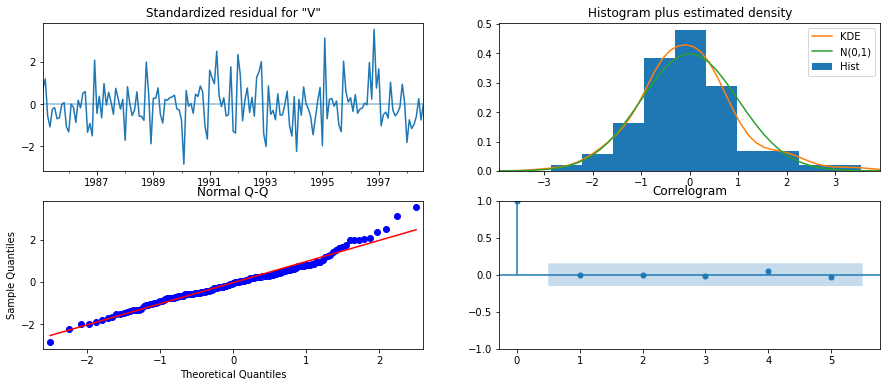

In [232]:
model_fit.plot_diagnostics(lags=5)


### 4.4 Análise do Ajuste

Text(0, 0.5, 'Vazão')

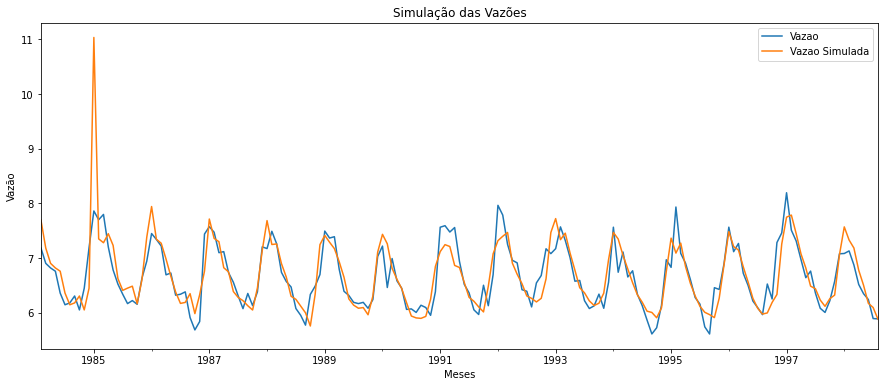

In [233]:
residual = pd.DataFrame(model_fit.resid, columns=['Vazao_Residual'])

series_adjusted = pd.concat([train, residual], axis=1)
series_adjusted.dropna(axis=0, inplace=True)
series_adjusted['Vazao Simulada'] = series_adjusted['Vazao'] - series_adjusted['Vazao_Residual']

series_adjusted.drop(columns=['Vazao_Residual'], inplace=True)

date = datetime.strptime('1984-01-01', '%Y-%m-%d')
series_adjusted = series_adjusted.drop(index=date)


series_adjusted.plot()
plt.title('Simulação das Vazões')
plt.xlabel('Meses')
plt.ylabel('Vazão')


### 4.5 Funções de Projeção

In [234]:
def get_forecast(months_ahead):
    result = model_fit.get_forecast(steps=len(test)+months_ahead)
    summ = pd.DataFrame(result.summary_frame(alpha=0.05))
    return summ

In [235]:
def arrange_to_plot(forecast_series):
    se_mim = round(forecast_series['mean_se'].min(), 4)
    se_max = round(forecast_series['mean_se'].max(), 4)
    forecast_data.drop(columns=['mean_se'], inplace=True)

    dict = {}
    for name in forecast_series.columns: 
        dict[name] = name
    dict['mean'] = 'Vazao Projetada'
    dict['mean_ci_lower'] = 'Intervalo Inferior'
    dict['mean_ci_upper'] = 'Intervalo Superior'
    forecast_series.columns = [value for key, value in dict.items()]
    return forecast_series, se_mim, se_max

In [236]:
def plot_forecast(forecast_series, title):
    forecast_series.plot()
    plt.title(title)
    plt.xlabel('Meses')
    plt.ylabel('Vazão')

    plt.fill_between(forecast_series.index, 
                     forecast_series['Intervalo Inferior'], 
                     forecast_series['Intervalo Superior'], 
                     color='k', alpha=.15)
    return

In [237]:
def come_back_to_real(forecast_series):
    forecast_series['Vazao'] = round(np.exp(forecast_series['Vazao']), 1)
    forecast_series['Vazao Projetada'] = round(np.exp(forecast_series['Vazao Projetada']), 1)
    forecast_series['Intervalo Inferior'] = round(np.exp(forecast_series['Intervalo Inferior']), 1)
    forecast_series['Intervalo Superior'] = round(np.exp(forecast_series['Intervalo Superior']), 1)
    return forecast_series


### 4.6 Teste

Aplicação dos dados de teste para comparação com o resultado

MSE: Mínimo = 0.2672; Máximo = 0.5193 e Diferença 0.2521


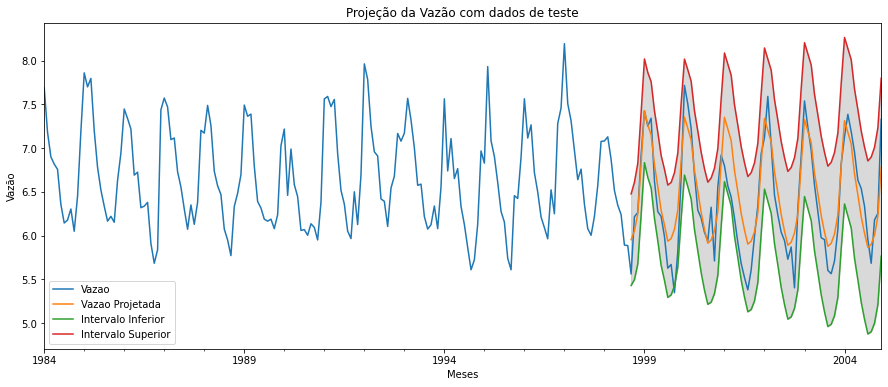

In [238]:
# Obtém a projeção para a série original.
summ = get_forecast(0)

forecast_data = pd.concat([series, summ], axis=1)

forecast_data, se_mim, se_max = arrange_to_plot(forecast_data)

print(f'MSE: Mínimo = {round(se_mim, 4)}; Máximo = {round(se_max, 4)} e Diferença {round(se_max - se_mim, 4)}')

plot_forecast(forecast_data, 'Projeção da Vazão com dados de teste')

### 4.7. Conclusão

As plotagens das funções de autocorrelação e autocorrelação parcial indicam para um modelo de média móvel de ordem 1. Então, foi definido a ordem ARIMA(train, order=(0,1,1), seasonal_order=(1,1,1,12)) com AIC igual a 84.485.

Experimentando uma variação dos parâmetros, chegou-se ao modelo ARIMA(train, order=(3,1,1), seasonal_order=(1,1,1,12)) que apresentou o AIC igual a 79.898

Ambos apresentam resídulos aderente a distribuição normal com respectivo FAC sem apresentar auto-correlação, assim como na análise visual na Simulação dos Vazões, a diferença não foi significante.

Analisando o Mean Square Error mínimo e máximo dos dois modelos sobre a projeção (Seção 5), pode-se observar que o modelo 2 apresenta medidas mais adequadas. Portanto o modelo 2 foi selecionado.

Modelo MA    MSE: Mínimo = 0.2731; Máximo = 0.5318; AIC = 84.485

Modelo ARIMA MSE: Mínimo = 0.2635; Máximo = 0.3323; AIC = 79.898

<div class="alert alert-info" style="background-color:#A6A6A6; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'>5. Validação</h2>
</div>

### 5.1.  Validação de 2005

Será incluído as vazões do ano de 2005 para comparar com o projetado.

MSE: Mínimo = 0.2672; Máximo = 0.5564 e Diferença 0.2892


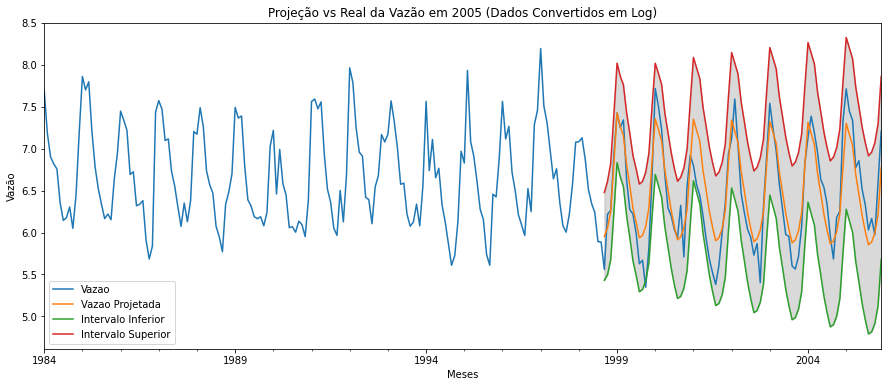

In [239]:
# A série termina em dez/2004 então será projetado 12 meses a frente
summ = get_forecast(12)

real_2005 = pd.read_csv('Vazoes-2005.csv', sep=';', header=0, index_col=0, date_parser=date_parser)

real_2005['Vazao'] = np.log(real_2005['Vazao'])

real_add = pd.concat([series, real_2005])

forecast_data = pd.concat([real_add, summ], axis=1)

forecast_data, se_mim, se_max = arrange_to_plot(forecast_data)

print(f'MSE: Mínimo = {round(se_mim, 4)}; Máximo = {round(se_max, 4)} e Diferença {round(se_max - se_mim, 4)}')

plot_forecast(forecast_data, 'Projeção vs Real da Vazão em 2005 (Dados Convertidos em Log)')

             Vazao  Vazao Projetada  Intervalo Inferior  Intervalo Superior
2005-01-01  2239.0           1482.8               532.4              4129.8
2005-02-01  1713.0           1299.4               463.9              3639.1
2005-03-01  1541.0           1137.4               403.9              3203.1
2005-04-01   874.0            807.0               285.0              2285.0
2005-05-01   950.0            635.5               223.2              1809.4
2005-06-01   676.0            495.5               173.1              1418.2
2005-07-01   561.0            409.2               142.2              1177.5
2005-08-01   416.0            348.2               120.3              1007.3
2005-09-01   477.0            360.4               123.4              1052.3
2005-10-01   392.0            400.6               136.3              1177.3
2005-11-01   721.0            497.7               168.3              1472.0
2005-12-01  1352.0            872.0               293.0              2594.8


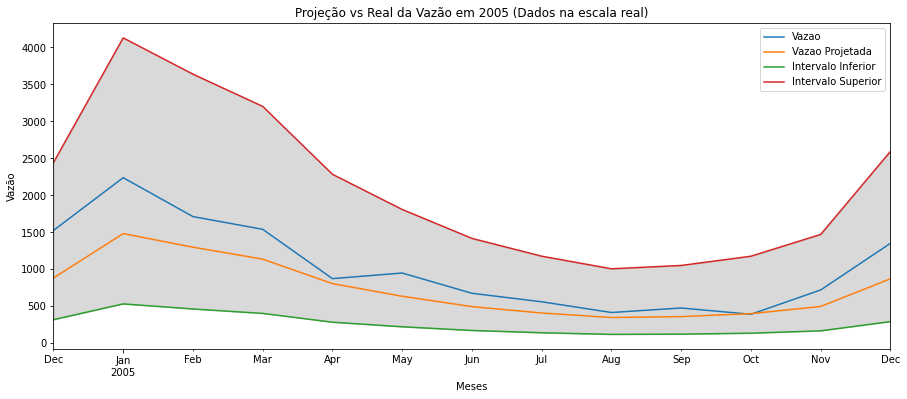

In [240]:
forecast_data = come_back_to_real(forecast_data)

threshold = datetime.strptime('2004-12-01', '%Y-%m-%d')

forecast_data = forecast_data.loc[forecast_data.index >= threshold]

print(forecast_data.tail(12))

plot_forecast(forecast_data, 'Projeção vs Real da Vazão em 2005 (Dados na escala real)')

### 5.2.  Validação de 2006


MSE: Mínimo = 0.2672; Máximo = 0.5935 e Diferença 0.3263


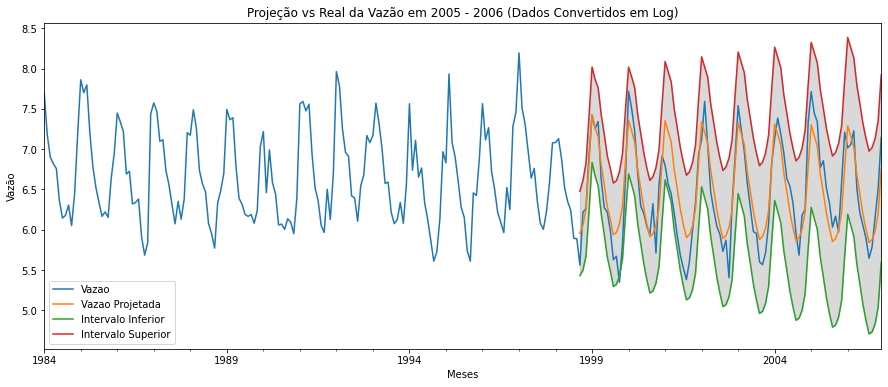

In [241]:
# A série termina em dez/2004 então será projetado 24 meses a frente
summ = get_forecast(24)

real_2006 = pd.read_csv('Vazoes-2006.csv', sep=';', header=0, index_col=0, date_parser=date_parser)

real_2006['Vazao'] = np.log(real_2006['Vazao'])

real_add = pd.concat([series, real_2005, real_2006])

forecast_data = pd.concat([real_add, summ], axis=1)

forecast_data, se_mim, se_max = arrange_to_plot(forecast_data)

print(f'MSE: Mínimo = {round(se_mim, 4)}; Máximo = {round(se_max, 4)} e Diferença {round(se_max - se_mim, 4)}')

plot_forecast(forecast_data, 'Projeção vs Real da Vazão em 2005 - 2006 (Dados Convertidos em Log)')

             Vazao  Vazao Projetada  Intervalo Inferior  Intervalo Superior
2005-01-01  2239.0           1482.8               532.4              4129.8
2005-02-01  1713.0           1299.4               463.9              3639.1
2005-03-01  1541.0           1137.4               403.9              3203.1
2005-04-01   874.0            807.0               285.0              2285.0
2005-05-01   950.0            635.5               223.2              1809.4
2005-06-01   676.0            495.5               173.1              1418.2
2005-07-01   561.0            409.2               142.2              1177.5
2005-08-01   416.0            348.2               120.3              1007.3
2005-09-01   477.0            360.4               123.4              1052.3
2005-10-01   392.0            400.6               136.3              1177.3
2005-11-01   721.0            497.7               168.3              1472.0
2005-12-01  1352.0            872.0               293.0              2594.8
2006-01-01  

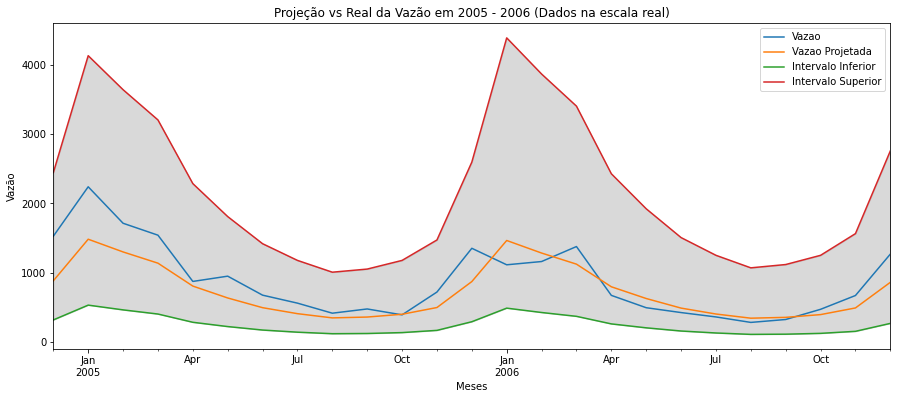

In [242]:
forecast_data = come_back_to_real(forecast_data)

threshold = datetime.strptime('2004-12-01', '%Y-%m-%d')

forecast_data = forecast_data.loc[forecast_data.index >= threshold]

print(forecast_data.tail(24))

plot_forecast(forecast_data, 'Projeção vs Real da Vazão em 2005 - 2006 (Dados na escala real)')

<div class="alert alert-info" style="background-color:#A6A6A6; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'>6. Resultado</h2>
</div>
